# Online VMP of AR(p) (no measurement noise)
State space model
\begin{align*}
    &\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{n} \quad \mathbf{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma^{-1}) \\
    &y_n = \mathbf{c}^\text{T}\mathbf{x}_n
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1}, \mathbf{I}\gamma^{-1} \right)\\
    &p(y_n\,|\,\mathbf{x}_{n}) = \mathcal{N}\left(y_n \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_n, \epsilon \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
    &\epsilon = 1\text{e}-12
\end{align*}

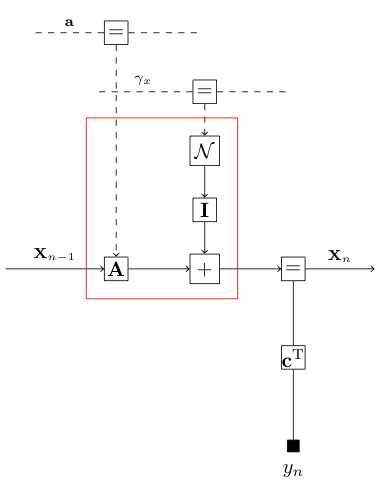

In [1]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in an estimation of the AR coefficients $\mathbf{a}$, while setting process noise precision $\gamma=1$.

In [2]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [3]:
ARorder = 10 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
process_noise = b_w/a_w
coefs, x = generate_data(1000, ARorder, 1, noise_variance=process_noise)

# Observations
y = [xi[1] for xi in x[ARorder:end]]

991-element Array{Float64,1}:
  1.4723308916155116 
  2.8122836704852148 
 -2.613609747308653  
 -0.728893504492113  
 -1.3867911574331582 
  3.1665954639378624 
  0.9421631776745938 
 -1.2566083462111592 
 -3.9020608675273047 
  1.1809912464928352 
 -0.7052245554896261 
  1.3227014627059086 
 -0.6780222031159692 
  ⋮                  
 -2.276666803371503  
 -0.6863712527775481 
 -1.154713055330405  
  3.2703437601909107 
  0.12322158755254586
 -0.515486924260978  
 -3.670622715288489  
 -0.5806162099864103 
  0.9769015250656672 
  6.001424005769367  
 -2.2398496799586756 
 -3.284395143252911  

In [4]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, huge)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11214080161822840105 -->
 
 11214080161822840105 
 
 clamp_3 
 
<!-- 2709720001764337711 -->
 
 2709720001764337711 
 
 placeholder_m_x_t_prev 
 
<!-- 17341857447844872295 -->
 
 17341857447844872295 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 2709720001764337711--17341857447844872295 -->
 
 2709720001764337711--17341857447844872295 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 13954475770057976055 -->
 
 13954475770057976055 
 
 dot 
 dotproduct_1 
 
<!-- 4613770593112481800 -->
 
 4613770593112481800 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 13954475770057976055--4613770593112481800 -->
 
 13954475770057976055--4613770593112481800 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17228468090852564521 -->
 
 17228468090852564521 
 
 Autoregression 
 autoregression_1 
 
<!-- 13954475770057976055--17228468090852564521 -->
 
 13954475770057976055--17228468090852564521 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 13543570411725548429 -->
 
 13543570411725548429 
 
 clamp_4 
 
<!-- 13954475770057976055--13543570411725548429 -->
 
 13954475770057976055--13543570411725548429 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 3149614084709977557 -->
 
 3149614084709977557 
 
 clamp_1 
 
<!-- 16510877102822519846 -->
 
 16510877102822519846 
 
 placeholder_m_a_t 
 
<!-- 600623162079686158 -->
 
 600623162079686158 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 16510877102822519846--600623162079686158 -->
 
 16510877102822519846--600623162079686158 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 4613770593112481800--11214080161822840105 -->
 
 4613770593112481800--11214080161822840105 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 2733252009478497260 -->
 
 2733252009478497260 
 
 placeholder_w_x_t_prev 
 
<!-- 2733252009478497260--17341857447844872295 -->
 
 2733252009478497260--17341857447844872295 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 16480341446495348637 -->
 
 16480341446495348637 
 
 Gam 
 gamma_1 
 
<!-- 16480341446495348637--3149614084709977557 -->
 
 16480341446495348637--3149614084709977557 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 6175203988912209006 -->
 
 6175203988912209006 
 
 clamp_2 
 
<!-- 16480341446495348637--6175203988912209006 -->
 
 16480341446495348637--6175203988912209006 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 17228468090852564521--16480341446495348637 -->
 
 17228468090852564521--16480341446495348637 
 
 w 
 1 out 
 4 W 
 
<!-- 17228468090852564521--17341857447844872295 -->
 
 17228468090852564521--17341857447844872295 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 17228468090852564521--600623162079686158 -->
 
 17228468090852564521--600623162079686158 
 
 a 
 1 out 
 3 a 
 
<!-- 11820321235883543873 -->
 
 11820321235883543873 
 
 placeholder_m_y_t 
 
<!-- 11820321235883543873--4613770593112481800 -->
 
 11820321235883543873--4613770593112481800 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 13877758447713651624 -->
 
 13877758447713651624 
 
 placeholder_w_a_t 
 
<!-- 13877758447713651624--600623162079686158 -->
 
 13877758447713651624--600623162079686158 
 
 w_a_t 
 3 w 
 1 out

In [5]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [6]:
# Define values for prior statistics
m_a_0 = 1.0*randn(ARorder)
w_a_0 = (tiny*diagAR(ARorder))
m_x_prev_0 = 1.0*randn(ARorder)
w_x_prev_0 = (0.001*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [7]:
marginals = Dict()
# VMP iterations
n_its = 10
# Storage for predictions
predictions = []

# Storage for MSE of test set
MSEs = []
# making first dummy prediction
push!(predictions, m_a_t_min'm_x_t_prev_min)
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    push!(MSEs, mse(predictions, y[1:t]))
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    predicted = m_a[t]'m_x_prev[t]
    push!(predictions, predicted)
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


In [8]:
using Plots
# Plotting predictions
toshow = 10 # number of points to plot at once (length(predictions) - length(y) = 1)
anim = @animate for i in 1:length(predictions)-toshow-1
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(y) - .1, maximum(y) + .1);
    plot!(collect(i:i+toshow), y[i:i+toshow], xlabel="observation", ylabel="value", label="actual")
    plot!(collect(i:i+toshow+1), predictions[i:i+toshow+1], label="predicted")
end;

In [9]:
gif(anim, "../gifs/predictions.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/predictions.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/predictions.gif")

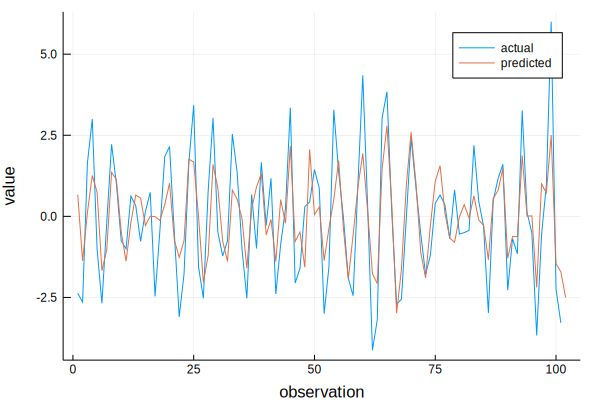

In [10]:
from = length(y) - 100
plot(y[from:end], xlabel="observation", ylabel="value", label="actual")
plot!(predictions[from:end], label="predicted")

In [62]:
# Plotting MSE
anim = @animate for i in 1:length(MSEs)
    s = plot()
    ylims!(minimum(MSEs) - 1, maximum(MSEs) + 1)
    xlims!(1, length(MSEs))
    plot!(collect(1:i), MSEs[1:i], xlabel="observation", ylabel="MSE", label="")
end;

In [65]:
gif(anim, "../gifs/MSE_evo.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo.gif")

In [14]:
# Plotting AR coefs
# !!! ONLY FOR AR(2)
using LinearAlgebra; 

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

anim = @animate for i in 1:100:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    xlims!(-1.0, 1.0)
    ylims!(-1.0, 1.0)
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)
    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel="a1", ylabel="a2")
end;

In [15]:
gif(anim, "../gifs/kpcoefs_evo.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/kpcoefs_evo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/kpcoefs_evo.gif")